In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube.models import SkyModel, SkyModels, BackgroundModel
from gammapy.cube import MapDataset, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.utils.fitting import Fit
from gammapy.data import FixedPointingInfo

import emcee

## Simulate an observation


In [2]:
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)

In [3]:
# Define sky model to simulate the data
spatial_model = SkyGaussian(lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.2 deg")
spectral_model = PowerLaw(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)
print(sky_model)

SkyModel

Parameters: 

	   name     value   error      unit         min    max frozen
	--------- --------- ----- -------------- --------- --- ------
	    lon_0 2.000e-01   nan            deg       nan nan  False
	    lat_0 1.000e-01   nan            deg       nan nan  False
	    sigma 2.000e-01   nan            deg 0.000e+00 nan  False
	    index 3.000e+00   nan                      nan nan  False
	amplitude 1.000e-11   nan cm-2 s-1 TeV-1       nan nan  False
	reference 1.000e+00   nan            TeV       nan nan   True


In [4]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.05, width=(3,3), coordsys="GAL", axes=[axis]
)


# Define some observation parameters
pointing = SkyCoord(0 *u.deg,0 *u.deg,frame='galactic') #FixedPointingInfo.read("$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_110380.fits")


In [5]:
def simulate_3d(sky_model,geom,pointing,
                irfs,livetime=1*u.h):
    
    """
    Simulate a source defined with a sky model for a given pointing,
    geometry and irfs for a given exposure time.
    This will return a dataset object.
    
    """
    
    
    background = make_map_background_irf(pointing=pointing,
                                         ontime=livetime, bkg=irfs["bkg"], geom=geom)
    
    psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
    psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=0.3 * u.deg)
    
    
    exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom)
    
    evaluator_src = MapEvaluator(   
    model=sky_model,
    exposure=exposure,
    psf=psf_kernel,
    edisp=edisp)
    
    npred_src = evaluator_src.compute_npred()
    background_model = BackgroundModel(background)
    npred_bkg = background_model.evaluate()

    npred_data = npred_src.data + npred_bkg.data
    npred_map = WcsNDMap(geom, npred_data)
    
    counts = np.random.poisson(npred_data)
    counts_map = WcsNDMap(geom, counts)
    
    
    dataset = MapDataset(
    model=sky_model,
    counts=counts_map,
    exposure=exposure,
    background_model=background_model,
    psf=psf_kernel)
    
    return dataset


dataset = simulate_3d(sky_model,geom,pointing,
                irfs,livetime=1*u.h)   

AttributeError: 'SkyCoord' object has no attribute 'altaz_frame'

In [105]:
sky_model.parameters["sigma"].frozen = False
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True
sky_model.parameters["amplitude"].frozen = True

background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

sky_model.parameters["index"].min = 0
sky_model.parameters["index"].max = 5
sky_model.parameters["amplitude"].min = 0
sky_model.parameters["amplitude"].max = 100

sky_model.parameters["sigma"].min = 0
sky_model.parameters["sigma"].max = 1


dataset = MapDataset(
    model=sky_model,
    counts=counts_map,
    exposure=exposure,
    background_model=background_model,
    psf=psf_kernel,
)
fit = Fit(dataset,backend='mcmc')
result = fit.run(optimize_opts={"print_level": 1})
#result = fit.run()


FCN = 11386.681960379627 
 TOTAL NCALL = 39 
 NCALLS = 39 
 
 
 EDM = 2.1148920873589826e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_lon_0,2,1,0,0,,,FIXED
2,par_001_lat_0,1,1,0,0,,,FIXED
3,par_002_sigma,1.98601,0.0323269,0,0,0.0,10.0,
4,par_003_index,2.99397,0.0131432,0,0,0.0,5.0,
5,par_004_amplitude,1,1,0,0,0.0,10000000000000.0,FIXED
6,par_005_reference,1,1,0,0,,,FIXED
7,par_006_norm,1,1,0,0,,,FIXED
8,par_007_tilt,0,1,0,0,,,FIXED
9,par_008_reference,1,1,0,0,,,FIXED


AttributeError: 'iminuit._libiminuit.Minuit' object has no attribute 'np_covariance'

## Fit the data with MCMC

Now let's analyse the simulated data.
Here we just fit it again with the same model we had before as a starting point.
The data that would be needed are the following: 
- counts_map, background_model, psf, exposure

We will need to define a Likelihood function and define priors on parameters.
Here we will assume a uniform prior reading the min, max parameters from the sky model.


In [143]:
# Prior functions

def uniform_prior(value, umin, umax):
    """Uniform prior distribution.
    """
    if umin <= value <= umax:
        return 0.0
    else:
        return -np.inf

def normal_prior(value, mean, sigma):
    """Normal prior distribution.
    """
    return -0.5 * (2 * np.pi * sigma) - (value - mean)**2 / (2. * sigma)

In [173]:

def model_to_par(dataset):
    
    pars=[]
    for p in dataset.parameters.free_parameters:
            pars.append(p.factor)

    return pars

def lnprior(dataset):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter limits should be done here through uniform prior ditributions
    """
    
    logprob=0
    for par in dataset.parameters.free_parameters:
        logprob += uniform_prior(par.value,par.min,par.max) #Should it read value or factor after autoscale?
    
    return logprob


def lnprob(pars,dataset,verb=False):
    """
    Estimate the likelihood of a model including prior on parameters.
    """
#    model= pars
    
    
    #Update model parameters factors inplace
    for factor, par in zip(pars,dataset.parameters.free_parameters):
        par.factor = factor
    
    lnprob_priors = lnprior(dataset)    
    
    # None is not read. LL with current state of model in dataset
    # WARNING: dataset.likelihood returns Cash statistics values
    # emcee will maximisise the LogLikelihood so we need -dataset.likelihood
    total_lnprob = -dataset.likelihood(None) + lnprob_priors  

    
    if verb:
        print("Parameters are:",pars)    
        print('LL=',total_lnprob)
        for p in dataset.parameters.free_parameters:
            print(p)
        print("")
        
    return total_lnprob

In [220]:
# Define sky model to simulate the data
spatial_model = SkyGaussian(lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.2 deg")
spectral_model = PowerLaw(
    index=2, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)


sky_model.parameters["sigma"].frozen = False
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True
sky_model.parameters["amplitude"].frozen = False
sky_model.parameters["index"].frozen = False

background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

sky_model.parameters["index"].min = 1
sky_model.parameters["index"].max = 5
sky_model.parameters["amplitude"].min = 0.01 *sky_model.parameters["amplitude"].value
sky_model.parameters["amplitude"].max = 100  *sky_model.parameters["amplitude"].value

sky_model.parameters["sigma"].min = 0.05
sky_model.parameters["sigma"].max = 1

dataset = MapDataset(
    model=sky_model,
    counts=counts_map,
    exposure=exposure,
    background_model=background_model,
    psf=psf_kernel,
)

print(dataset.model)

SkyModel

Parameters: 

	   name     value   error      unit         min       max    frozen
	--------- --------- ----- -------------- --------- --------- ------
	    lon_0 2.000e-01   nan            deg       nan       nan   True
	    lat_0 1.000e-01   nan            deg       nan       nan   True
	    sigma 2.000e-01   nan            deg 5.000e-02 1.000e+00  False
	    index 2.000e+00   nan                1.000e+00 5.000e+00  False
	amplitude 1.000e-11   nan cm-2 s-1 TeV-1 1.000e-13 1.000e-09  False
	reference 1.000e+00   nan            TeV       nan       nan   True


In [223]:
%%time
nwalkers=32

#Need to initiate the position of each walker
dataset.parameters.autoscale() #Autoscale parameters
pars=model_to_par(dataset) #get a tuple of parameters from dataset
ndim=len(pars)

# Initialize walkers in a ball of relative size 0.5% in all dimensions if the
# parameters have been fit, or to 10% otherwise
spread=0.5/100
p0var = np.array([spread * pp for pp in pars])
p0 = emcee.utils.sample_ball(pars, p0var, nwalkers)


print('First guess for each walker is:',p0)

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob,
                                args=[dataset],
                                threads=1)

pos, prob, state = sampler.run_mcmc(p0, 200)

First guess for each walker is: [[ 2.00259994  3.01370885  1.01118654]
 [ 1.99987925  2.98538     1.01788542]
 [ 2.0002462   3.00857807  1.01235465]
 [ 2.00024247  3.00827731  1.02432561]
 [ 1.99867548  2.99153852  1.00836304]
 [ 1.99712878  3.01090309  1.02551247]
 [ 2.0134662   3.00083349  1.01485624]
 [ 1.99257973  3.01000457  1.02515067]
 [ 1.97521021  3.01149034  1.01972903]
 [ 1.97467084  2.96602452  1.0098521 ]
 [ 2.01314341  2.99994406  1.00891838]
 [ 1.98792529  2.99560392  1.01763289]
 [ 2.00212797  2.99834534  1.02026626]
 [ 2.01591285  3.00234582  1.01297511]
 [ 2.01546259  2.97918347  1.02674294]
 [ 1.99179732  2.97451079  1.02156535]
 [ 1.99269028  2.99566162  1.0212163 ]
 [ 1.98445648  2.99685291  1.021055  ]
 [ 1.99327397  2.99718048  1.01598105]
 [ 1.99006567  2.98791782  1.01422358]
 [ 1.99156897  2.99280142  1.02183483]
 [ 1.99740337  3.00210806  1.01616287]
 [ 1.98239564  2.98685621  1.02018453]
 [ 1.99510679  2.98559234  1.01694347]
 [ 2.00515899  3.00816825  1.015

In [228]:
sampler.chain.shape

(32, 200, 3)

In [232]:
%%time
#If you use N threads you will see N warning when the objects are being save to a pickle
sampler = run_mcmc(dataset,nwalkers=32,nrun=500,nburn=0,threads=2)

CPU times: user 41.7 s, sys: 9.72 s, total: 51.5 s
Wall time: 1min 48s


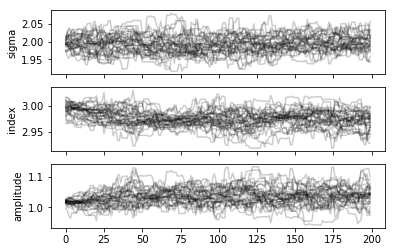

In [224]:
labels=[]
for p in dataset.parameters.free_parameters:
    labels.append(p.name)

fig, ax = plt.subplots(3, sharex=True)
for i in range(len(ax)):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)
    ax[i].set_ylabel(labels[i])

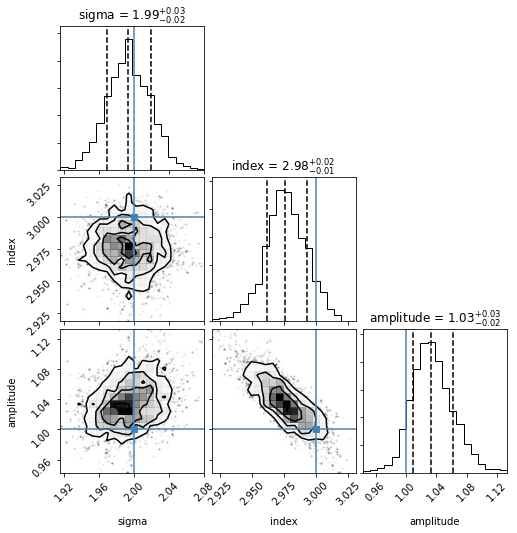

In [230]:
nburn=0
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))


#truths=[m_true, b_true], quantiles=[0.16, 0.5, 0.84], show_titles=True, labels_args={"fontsize": 40}
import corner
fig = corner.corner(samples,labels=labels,quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,truths=[2,3,1]) #, truths=[m_true, b_true, np.log(f_true)]

In [227]:
dataset.parameters.parameters

[Parameter(name='lon_0', value=0.2, factor=2.0, scale=0.1, unit='deg', min=nan, max=nan, frozen=True),
 Parameter(name='lat_0', value=0.1, factor=1.0, scale=0.1, unit='deg', min=nan, max=nan, frozen=True),
 Parameter(name='sigma', value=0.2040967801883901, factor=2.040967801883901, scale=0.1, unit='deg', min=0.05, max=1.0, frozen=False),
 Parameter(name='index', value=2.9673415699843675, factor=2.9673415699843675, scale=1.0, unit='', min=1.0, max=5.0, frozen=False),
 Parameter(name='amplitude', value=9.98759172556433e-12, factor=0.9987591725564331, scale=1e-11, unit='cm-2 s-1 TeV-1', min=9.999999999999999e-14, max=9.999999999999999e-10, frozen=False),
 Parameter(name='reference', value=1.0, factor=1.0, scale=1.0, unit='TeV', min=nan, max=nan, frozen=True),
 Parameter(name='norm', value=1.0, factor=1.0, scale=1.0, unit='', min=nan, max=nan, frozen=True),
 Parameter(name='tilt', value=0.0, factor=0.0, scale=1.0, unit='', min=nan, max=nan, frozen=True),
 Parameter(name='reference', value=

In [216]:

def run_mcmc(dataset,nwalkers=12,nrun=500,nburn=0,threads=1):
    """
    
    dataset:
    A gammapy dataset object. This contains the observed counts cube,
    the exposure cube, the psf cube, and the sky model and model.
    Each free parameter in the sky model is considered as parameter for the MCMC.
    
    nwalkers:
    Required integer number of walkers to use in ensemble.
    Minimum is 2*nparam+2, but more than that is usually better.
    Must be even to use MPI mode.
    
    nburn:
    Number of runs that will be discarded (burnt) until reaching ~stationary states for walkers.
    Hard to guess. Depends how close to best-fit you are. 
    Put nburn=0 and nrun=few hundreds to see the trend and choose a nburn.
    This step can be ~seen as the fitting step.
    
    nrun:
    Number of steps for walkers. Typically at least a few hundreds (but depends on dimensionality).
    Low nrun (<100?) will underestimate the errors. 
    Samples that would populate the distribution are nrun*nwalkers.
    This step can be ~seen as the error estimation step. 
    
    """
    
    
    dataset.parameters.autoscale() #Autoscale parameters
    pars=model_to_par(dataset) #get a tuple of parameters from dataset
    ndim=len(pars)

    # Initialize walkers in a ball of relative size 0.5% in all dimensions if the
    # parameters have been fit, or to 10% otherwise
    spread=0.5/100
    p0var = np.array([spread * pp for pp in pars])
    p0 = emcee.utils.sample_ball(pars, p0var, nwalkers)


#    print('First guess for each walker is:',p0)

    sampler = emcee.EnsembleSampler(nwalkers,
                                    ndim,
                                    lnprob,
                                    args=[dataset],
                                    threads=threads)

    pos, prob, state = sampler.run_mcmc(p0, nrun)
    
    return sampler

# Test Zone